In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import openturns as ot
import openturns.viewer as viewer
from matplotlib import cm, colormaps
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
ot.RandomGenerator.SetSeed(2)

In [3]:
from matplotlib import rc
rc('font', **{'family': 'Libertine'})
rc('text', usetex=True)
rc('font', size=16)# Set the default text font size
rc('axes', titlesize=20)# Set the axes title font size
rc('axes', labelsize=16)# Set the axes labels font size
rc('xtick', labelsize=16)# Set the font size for x tick labels
rc('ytick', labelsize=16)# Set the font size for y tick labels
rc('legend', fontsize=16)# Set the legend font size

In [4]:
#marginals = [ot.Normal(1., 2.), ot.Normal(1., 2.)]
marginals = [ot.InverseNormal(2.3, 6.8), ot.WeibullMin(2.3, 3.3, 2.)]
# Copulas 
correlation = ot.CorrelationMatrix(2)
correlation[1, 0] = 0.8
normal_copula= ot.NormalCopula(correlation)
clayton_copula = ot.ClaytonCopula(2.5)
# Distributions 
independent_distribution = ot.ComposedDistribution(marginals)
normal_distribution = ot.ComposedDistribution(marginals, normal_copula)
clayton_distribution = ot.ComposedDistribution(marginals, clayton_copula)

In [5]:
N = int(1e4)
cols = ["$H_s$", "$T_p$"]
df_independent = pd.DataFrame(np.array(independent_distribution.getSample(N)), columns=cols)
df_normal = pd.DataFrame(np.array(normal_distribution.getSample(N)), columns=cols)
df_clayton = pd.DataFrame(np.array(clayton_distribution.getSample(N)), columns=cols)

In [6]:
def joint_plot(df, alpha, color, xticks=None, yticks=None):
    g = sns.jointplot(data=df, x="$H_s$", y="$T_p$", height=4, marginal_ticks=False, 
                         marginal_kws=dict(bins=20, stat="probability", alpha=alpha), 
                         marker=".", alpha=alpha, color=color,
                         )
    g.plot_joint(sns.kdeplot, color=color, zorder=1, levels=6, alpha=alpha+0.4)
    if xticks is not None:
        g.ax_joint.set_xticks(xticks)
        g.ax_joint.set_yticks(yticks)
    return g
def empirical_copula_plot(df, alpha, color, xticks=None, yticks=None):
    g = sns.jointplot(data=df, x="$H_s$", y="$T_p$", height=4, marginal_ticks=False, 
                         marginal_kws=dict(bins=10, stat="probability", alpha=alpha), 
                         joint_kws=dict(bins=10),
                         alpha=alpha, color=color,
                         kind="hist"
                         )
    if xticks is not None:
        g.ax_joint.set_xticks(xticks)
        g.ax_joint.set_yticks(yticks)
    return g

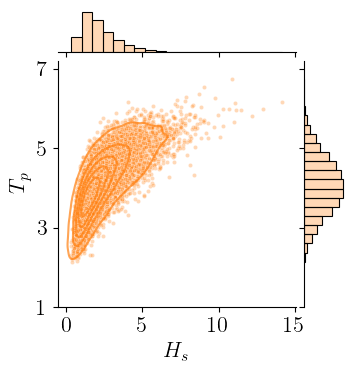

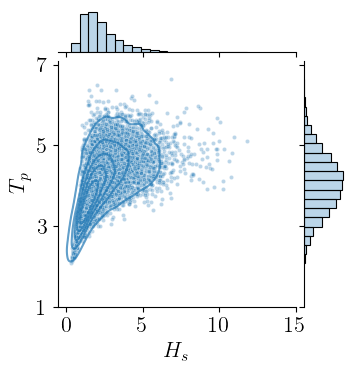

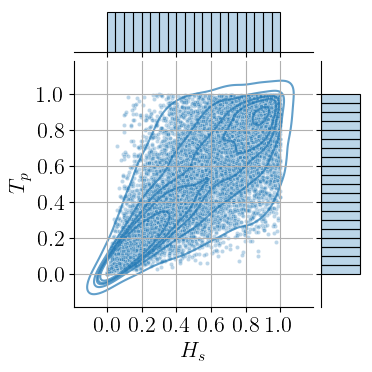

In [7]:
alpha = 0.3
# Joints plots in physical space
joint_plot(df_normal, alpha, "C1", xticks=[0, 5, 10, 15], yticks=[1, 3, 5, 7])
plt.savefig("figures/normal_copula_metocean.png", dpi=300, bbox_inches='tight')
joint_plot(df_clayton, alpha, "C0", xticks=[0, 5, 10, 15], yticks=[1, 3, 5, 7])
plt.savefig("figures/clayton_copula_metocean.png", dpi=300, bbox_inches='tight')
# # Joints plots in ranked space
joint_plot(df_clayton.rank() / N, alpha, "C0", xticks=[0, 0.2, 0.4, 0.6, 0.8, 1.], yticks=[0, 0.2, 0.4, 0.6, 0.8, 1.])
plt.grid()
plt.savefig("figures/clayton_copula_ranked_metocean.png", dpi=300, bbox_inches='tight')

## Empirical copula

In [8]:
greys = colormaps['Greys']
blues = colormaps['Blues']
reds = colormaps['Reds']
my_greys = ListedColormap(greys(np.linspace(0.25, 1, 128)))
my_blues = ListedColormap(blues(np.linspace(0.25, 1, 128)))
my_reds = ListedColormap(reds(np.linspace(0.2, 1, 128)))

In [9]:
class DrawFunctions:
    """
    """
    def __init__(self):
        self.dim = 2
        self.grid_size = 100
        lowerbound = [0.0] * self.dim
        upperbound = [1.0] * self.dim
        self.set_bounds(lowerbound, upperbound)

    def set_bounds(self, lowerbound, upperbound):
        mesher = ot.IntervalMesher([self.grid_size-1] * self.dim)
        interval = ot.Interval(lowerbound, upperbound)
        mesh = mesher.build(interval)
        self.nodes = mesh.getVertices()
        self.X0, self.X1 = np.array(self.nodes).T.reshape(self.dim, self.grid_size, self.grid_size)
        return None
    
    def draw_2D_surface(self, distributions, colorbars, alphas=[0.8]):
        fig = plt.figure(figsize=(3.5, 3))
        for dist, colorbar, alpha in zip(distributions, colorbars, alphas): 
            if dist.getClassName()=="Sample":
                Z = np.array([dist.computeEmpiricalCDF(n) for n in self.nodes]).reshape(self.grid_size, self.grid_size)
            else : 
                Z = np.array(dist.computePDF(self.nodes)).reshape(self.grid_size, self.grid_size)
            plt.contourf(self.X0, self.X1, Z, cmap=colorbar, alpha=alpha)

        plt.xlabel("$H_s$")
        plt.ylabel("$T_p$")
        plt.xticks(np.linspace(0, 1, 6))
        plt.yticks(np.linspace(0, 1, 6))
        return fig

    def draw_3D_surface(self, distributions, colorbars, alphas=[0.8]):
        fig, ax = plt.subplots(subplot_kw={'projection': '3d'})
        for dist, colorbar, alpha in zip(distributions, colorbars, alphas): 
            if dist.getClassName()=="Sample":
                Z = np.array([dist.computeEmpiricalCDF(n) for n in self.nodes]).reshape(self.grid_size, self.grid_size)
            else:
                Z = np.array(dist.computeCDF(self.nodes)).reshape(self.grid_size, self.grid_size)
            ax.plot_surface(self.X0, self.X1, Z, cmap=colorbar, alpha=alpha, rstride=10)
            ax.contour(self.X0, self.X1, Z, cmap=colorbar)
        ax.set_zticks([0.0, 1.0])
        ax.set_zlim(0., 1.)
        ax.set_xlabel("$x_1$")
        ax.set_ylabel("$x_2$")     
        ax.set_zlabel("CDF", rotation=90)
        ax.view_init(elev=30, azim=-120, roll=0)
        return fig, ax

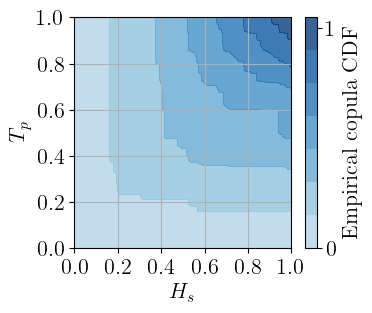

In [10]:
n = 100
copula_sample = clayton_copula.getSample(n)
d = DrawFunctions()
fig = d.draw_2D_surface([copula_sample], [my_blues], [0.8])
plt.colorbar(label="Empirical copula CDF", ticks=[0, 1])
plt.grid()
plt.savefig("figures/empirical_copula_metocean.png", dpi=300, bbox_inches='tight', pad_inches=0.4);

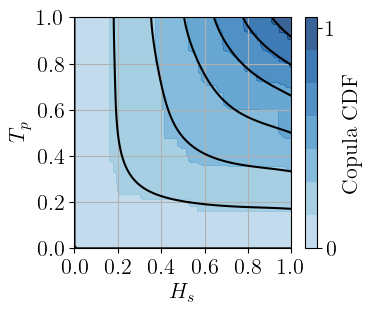

In [11]:
ebc = ot.EmpiricalBernsteinCopula(copula_sample, 10, True)
d = DrawFunctions()
d.draw_2D_surface([copula_sample], [my_blues, my_blues], [0.8, 0.8])
plt.colorbar(label="Copula CDF", ticks=[0, 1])
Z = np.array(ebc.computeCDF(d.nodes)).reshape(d.grid_size, d.grid_size)
plt.contour(d.X0, d.X1, Z, colors="k")
plt.grid()
plt.savefig("figures/bernstein_copula_metocean.png", dpi=300, bbox_inches='tight', pad_inches=0.4);

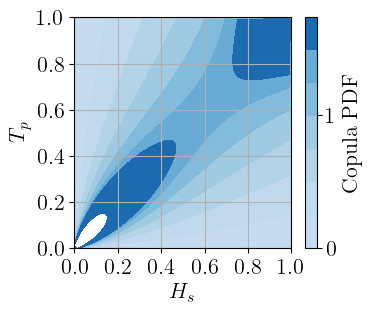

In [12]:
d = DrawFunctions()
fig = plt.figure(figsize=(3.5, 3))
Z = np.array(clayton_copula.computePDF(d.nodes)).reshape(d.grid_size, d.grid_size)
levels = [np.quantile(Z, i) for i in np.linspace(0.01, 0.99, 8)]
plt.contourf(d.X0, d.X1, Z, cmap=my_blues, levels=levels)
plt.colorbar(label="Copula PDF", ticks=[0, 1])
plt.xticks(np.linspace(0, 1, 6))
plt.yticks(np.linspace(0, 1, 6))
plt.grid()
plt.xlabel("$H_s$")
plt.ylabel("$T_p$")
plt.savefig("figures/joint_metocean_copula.png", dpi=300, bbox_inches='tight', pad_inches=0.4);

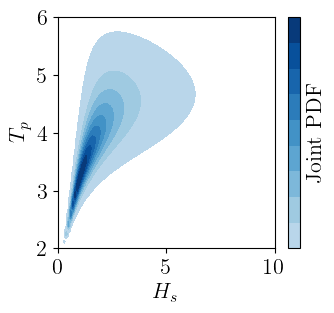

In [13]:
dist = ot.ComposedDistribution(marginals, clayton_copula)
d = DrawFunctions()
d.set_bounds([0, 2], [10, 6])
fig = plt.figure(figsize=(3.5, 3))
Z = np.array(dist.computePDF(d.nodes)).reshape(d.grid_size, d.grid_size)
plt.contourf(d.X0, d.X1, Z, cmap=my_blues, levels=np.linspace(0.01, 0.6, 10))
plt.colorbar(label="Joint PDF", ticks=[0, 1])
plt.xlabel("$H_s$")
plt.ylabel("$T_p$")
plt.savefig("figures/joint_metocean.png", dpi=300, bbox_inches='tight', pad_inches=0.4);

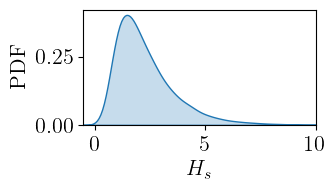

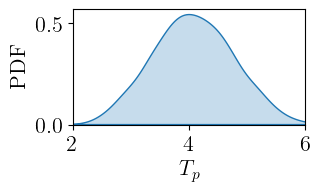

In [14]:
plt.figure(figsize=(3, 1.5))
ax1 = sns.kdeplot(data=df_normal["$H_s$"], bw_adjust=1.4, fill=True)
ax1.set_xlim([-0.5, 10])
ax1.set_ylabel("PDF")
plt.savefig("figures/Hs_metocean.png", dpi=300, bbox_inches='tight', pad_inches=0.4);

plt.figure(figsize=(3, 1.5))
ax2 = sns.kdeplot(data=df_normal["$T_p$"], bw_adjust=1.4, fill=True)
ax2.set_xlim([2, 6])
ax2.set_ylabel("PDF")
plt.savefig("figures/Tp_metocean.png", dpi=300, bbox_inches='tight', pad_inches=0.4);